### Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
import torch
from config import LabConfig
import torchmetrics
import transforms as T
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.dataset import FutureFramePredictorDataset
from utils.plot import RNN
from utils.model import Model
import pytorch_lightning as pl

import numpy as np

/opt/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
from model import NextFiveFramePredictor

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Models
#### ConvLSTM2D

In [5]:
class ConvLSTM2D(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super().__init__()  

        self.activation = torch.tanh 
        
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding, dtype=torch.float)           

        self.W_ci = nn.Parameter(torch.zeros(out_channels, *frame_size, dtype=torch.float))
        self.W_co = nn.Parameter(torch.zeros(out_channels, *frame_size, dtype=torch.float))
        self.W_cf = nn.Parameter(torch.zeros(out_channels, *frame_size, dtype=torch.float))

    def forward(self, X, H_prev, C_prev):
        
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)
        
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )
        
        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

#### ConvLSTM

In [6]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size, device):

        super().__init__()

        self.out_channels = out_channels
        self.device = device
        # We will unroll this over time steps
        self.frame_size = frame_size
        self.convLSTMcell1 = ConvLSTM2D(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)
    
    
    def setDevice(self, device):
        self.device = device
        
    def forward(self, X):
     
        height, width = self.frame_size
        
        batch_size, _, seq_len, _, _ = X.size()  
        
        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, dtype=torch.float, device=self.device)
        
        # Initialize Hidden State
        H =  torch.zeros(batch_size, self.out_channels, 
        height, width, dtype=torch.float, device=self.device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, dtype=torch.float, device=self.device)
        
        
        # Unroll over time steps
        for time_step in range(seq_len):
            
            
            H, C = self.convLSTMcell1(X[:,:, time_step], H, C)    
            output[:,:, time_step] = H
       
        return output

#### SequenceToSequence

In [7]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, device):

        super().__init__()
        
        self.frame_size = frame_size
        
        self.future_step = 5
        self.device = device
        
        self.convlstm1 = ConvLSTM(in_channels=num_channels, out_channels=num_kernels*2, 
                                  kernel_size=kernel_size, padding=padding, 
                                  activation=activation, frame_size=frame_size, device=device)
        
        
        self.convlstm2 = ConvLSTM(in_channels=num_kernels*2, out_channels=num_kernels*2, 
                                  kernel_size=kernel_size, padding=padding, 
                                  activation=activation, frame_size=frame_size, device=device)  
        
        
        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_channels,kernel_size=(3, 3), padding=(1, 1),
                             dtype=torch.float)
    
    
    def setDevice(self, device):
        self.device = device
        #print("Inside seq2seq", device)
        
        self.convlstm1.setDevice(device)
        self.convlstm2.setDevice(device)
        
    def forward(self, X):

        h, w = self.frame_size
        device = self.device
        
        batch = X.size(0) 
        
        X = X.view(batch, 3, 5, h, w).float().to(device)
        
        outputs = torch.zeros(batch, 3, 5, h, w)
        
        for frame in range(self.future_step):
            
            output = self.convlstm1(X)
            output = self.convlstm2(output)
            
            output = self.conv(output[:, :, -1])
            out = output
            X = torch.cat([X, output[:, :, None]], dim=2)
            outputs[:, :, frame] = out
            
            
        return nn.Sigmoid()(outputs.view(batch, -1, h, w).double())

### Config

In [10]:
cfg = LabConfig()
cfg.todict()

{'training_img_dir': '../../data/FlyingObjectDataset_10K/training/image',
 'validation_img_dir': '../../data/FlyingObjectDataset_10K/validation/image',
 'testing_img_dir': '../../data/FlyingObjectDataset_10K/testing/image',
 'SEQUENCE_LENGTH': 5,
 'SEED': 420,
 'GPU': 0,
 'IMAGE_WIDTH': 32,
 'IMAGE_HEIGHT': 32,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

In [11]:
cfg.BATCH_SIZE = 15

cfg.IMAGE_HEIGHT = 64
cfg.IMAGE_WIDTH = 64

In [12]:
cfg.todict()

{'BATCH_SIZE': 15,
 'IMAGE_HEIGHT': 64,
 'IMAGE_WIDTH': 64,
 'training_img_dir': '../../data/FlyingObjectDataset_10K/training/image',
 'validation_img_dir': '../../data/FlyingObjectDataset_10K/validation/image',
 'testing_img_dir': '../../data/FlyingObjectDataset_10K/testing/image',
 'SEQUENCE_LENGTH': 5,
 'SEED': 420,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'TENSORBORD_DIR': 'logs/'}

In [13]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST),
    T.RandomHorizontalFlip(0.2),
    T.RandomVerticalFlip(0.1),
])
test_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST), #, 
])

In [14]:
train_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.training_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=train_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS

)

valid_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.validation_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)

test_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.testing_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)

print("Data batch generators are created!")

Data batch generators are created!


In [15]:
t_x, t_y = next(iter(train_dataloader))

In [16]:
t = iter(train_dataloader)

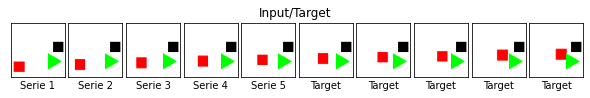

In [17]:
t_x, t_y = next(t)
RNN.data(t_x, t_y, cfg.SEQUENCE_LENGTH, nrows=1, title_size=3)

In [18]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":5e-3,
            'weight_decay':2e-7
        }
    },
    'criterion':torch.nn.MSELoss(), #torch.nn.MSELoss(reduction="sum"), # error function
    'max_epochs':80,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=1,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=1,compute_on_step=False),
    ],postfix="_Validation")
}

In [26]:
model = Seq2Seq(num_channels=3, num_kernels=16, kernel_size=(3, 3), padding=(1, 1), activation="tanh", 
                frame_size=(cfg.IMAGE_WIDTH, cfg.IMAGE_HEIGHT), device=device)

In [27]:
modelObj = NextFiveFramePredictor(model,**config)

In [28]:
# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[pl.callbacks.progress.TQDMProgressBar()], 
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,
            precision=16,
        )

# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader,
);

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [29]:
loss = trainer.test(test_dataloaders = test_dataloader)

Restoring states from the checkpoint path at logs/default/version_559/checkpoints/epoch=79-step=5119.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at logs/default/version_559/checkpoints/epoch=79-step=5119.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss_Test': 0.004175097681581974}
--------------------------------------------------------------------------------



In [30]:
model.setDevice('cpu')

In [31]:
model = model.cpu()

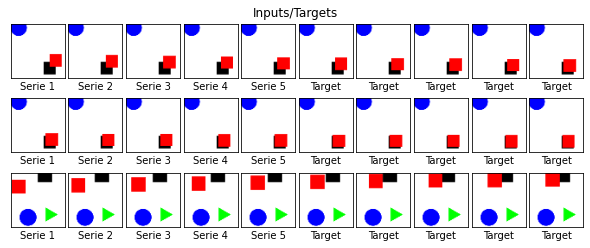

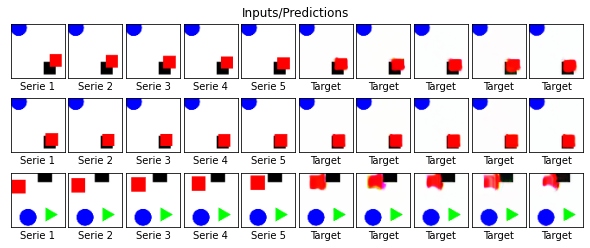

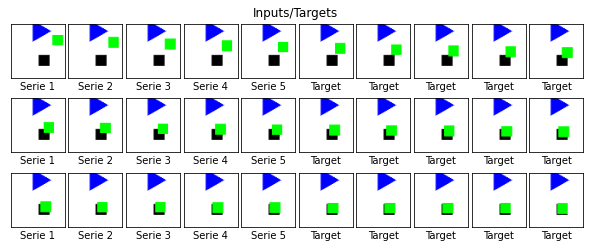

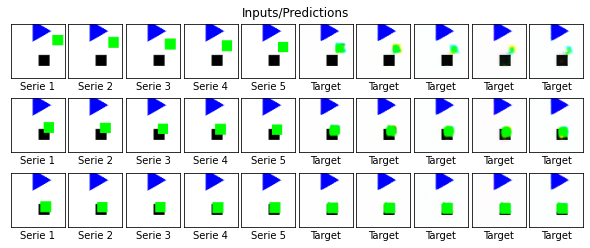

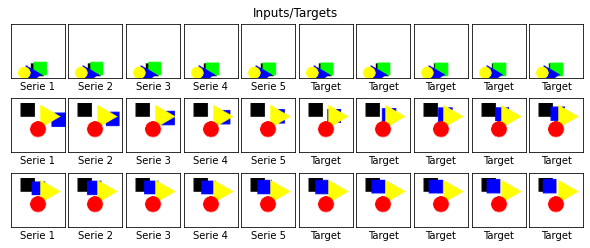

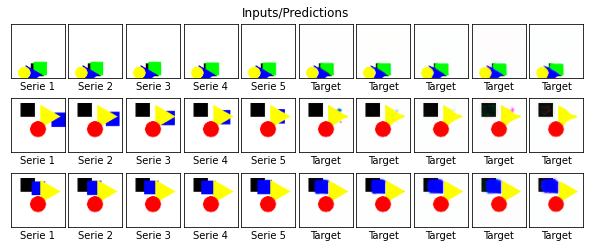

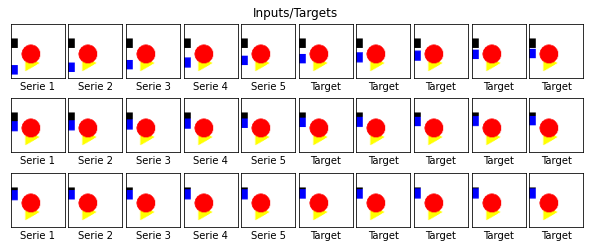

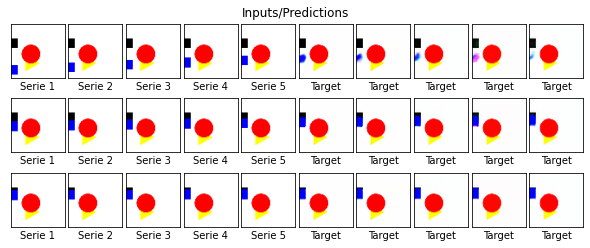

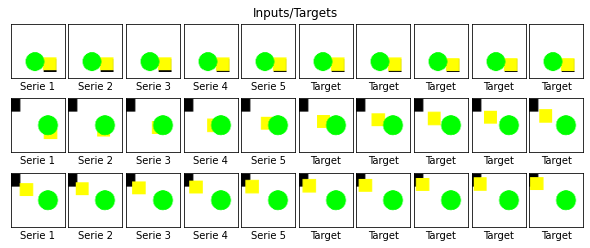

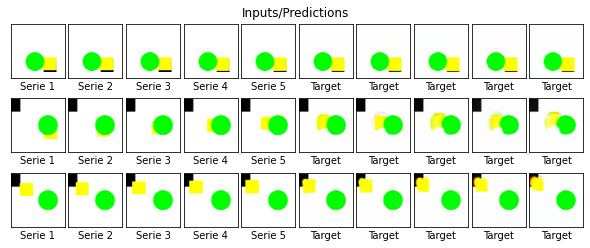

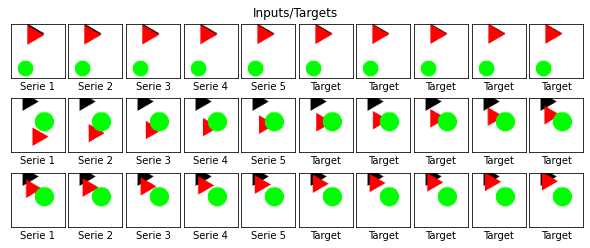

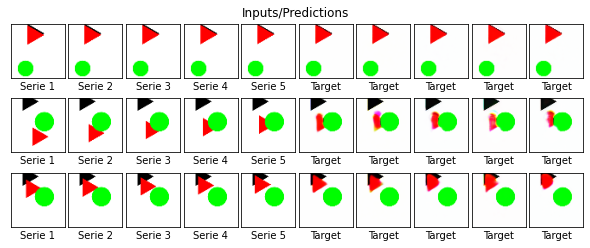

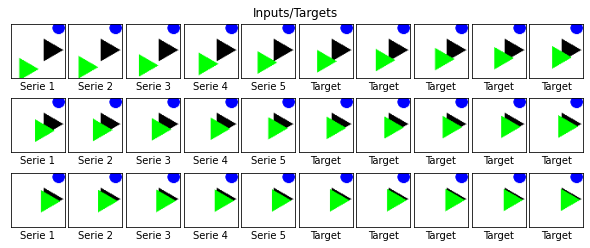

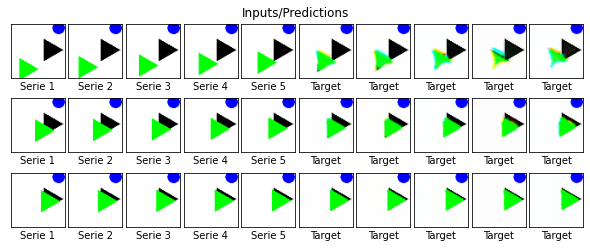

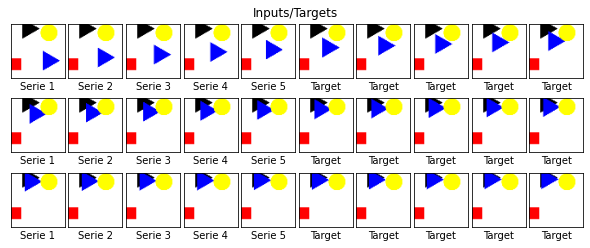

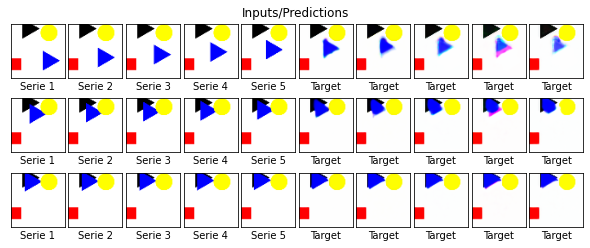

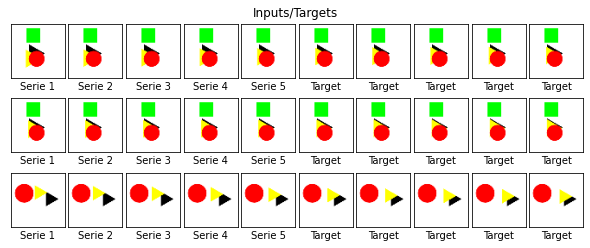

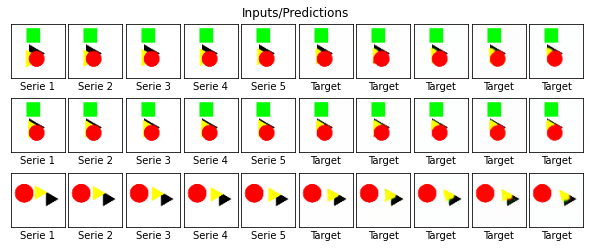

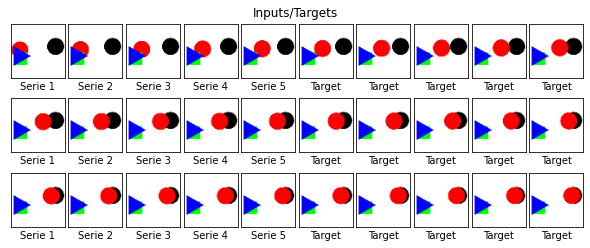

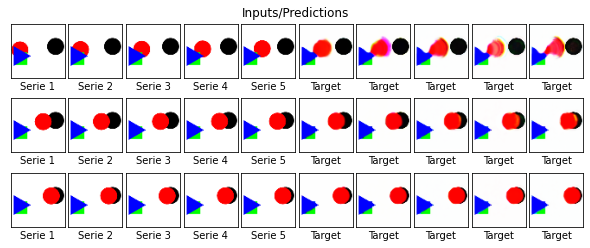

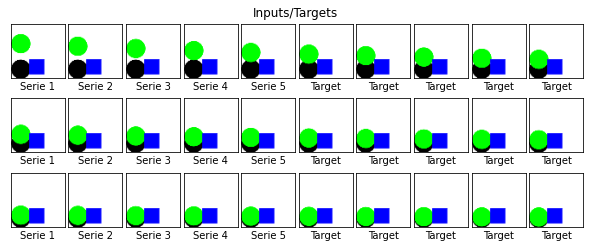

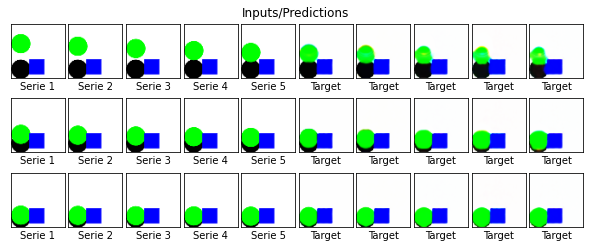

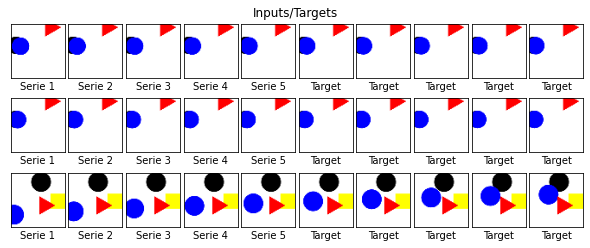

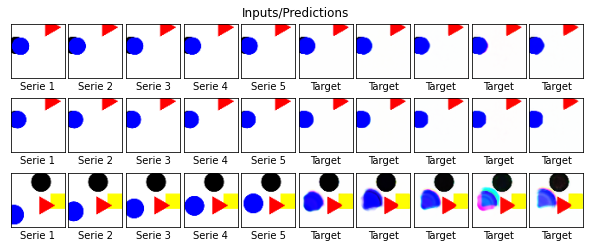

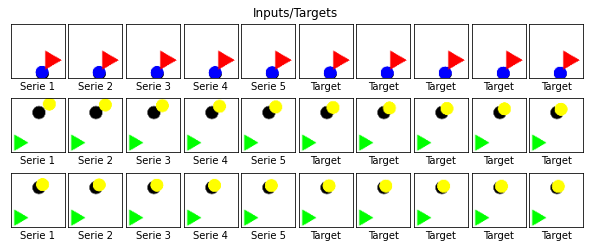

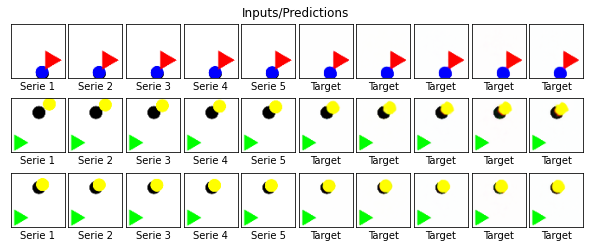

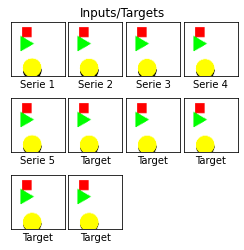

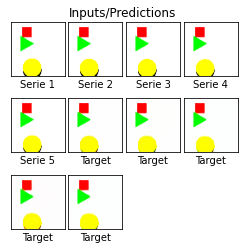

In [32]:
for batch_index, (x, y) in enumerate(test_dataloader, 1):
    x,y = x.cpu(), y.cpu()
    preds = model(x).cpu().detach()
    RNN.data(x, y, cfg.SEQUENCE_LENGTH, nrows=3, title="Inputs/Targets")
    RNN.data(x, preds, cfg.SEQUENCE_LENGTH, nrows=3, title="Inputs/Predictions")